In [3]:
!pip install pyspark

In [4]:
from google.colab import files

# Subir el archivo
uploaded = files.upload()

Saving session_Pilates.csv to session_Pilates.csv
Saving session_Spinning.csv to session_Spinning.csv
Saving session_yoga.csv to session_yoga.csv
Saving user_age.csv to user_age.csv


In [5]:
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster("local").setAppName("My App")

In [6]:
sc = SparkContext.getOrCreate(conf=conf)

In [7]:
from pyspark.sql import SparkSession

# Crear una SparkSession
spark = SparkSession.builder.appName("My CSV App").getOrCreate()

In [8]:
df_pilates_path = "/content/session_Pilates.csv"
df_yoga_path = "/content/session_yoga.csv"
df_spinning_path = "/content/session_Spinning.csv"
df_age_path = "/content/user_age.csv"

df_pilates = spark.read.csv(df_pilates_path, header=True, inferSchema=True)
df_yoga = spark.read.csv(df_yoga_path, header=True, inferSchema=True)
df_spinning = spark.read.csv(df_spinning_path, header=True, inferSchema=True)
df_age = spark.read.csv(df_age_path, header=True, inferSchema=True)

In [9]:
df_age = df_age.filter((df_age['edad'] > 18) & (df_age['edad'] < 60))
df_age = df_age.withColumnRenamed("user", "user_age")

#DF solo con los usuarios de la classe entre edades 18 i 60
df_pilates = df_pilates.join(df_age, df_pilates["user"] == df_age["user_age"], "inner")
df_yoga = df_yoga.join(df_age, df_yoga["user"] == df_age["user_age"], "inner")
df_spinning = df_spinning.join(df_age, df_spinning["user"] == df_age["user_age"], "inner")

In [10]:
df_pilates_agrupado = df_pilates.groupBy("edad").count()
df_yoga_agrupado = df_yoga.groupBy("edad").count()
df_spinning_agrupado = df_spinning.groupBy("edad").count()

df_yoga_agrupado = df_yoga_agrupado.orderBy("edad")
df_pilates_agrupado = df_pilates_agrupado.orderBy("edad")
df_spinning_agrupado = df_spinning_agrupado.orderBy("edad")

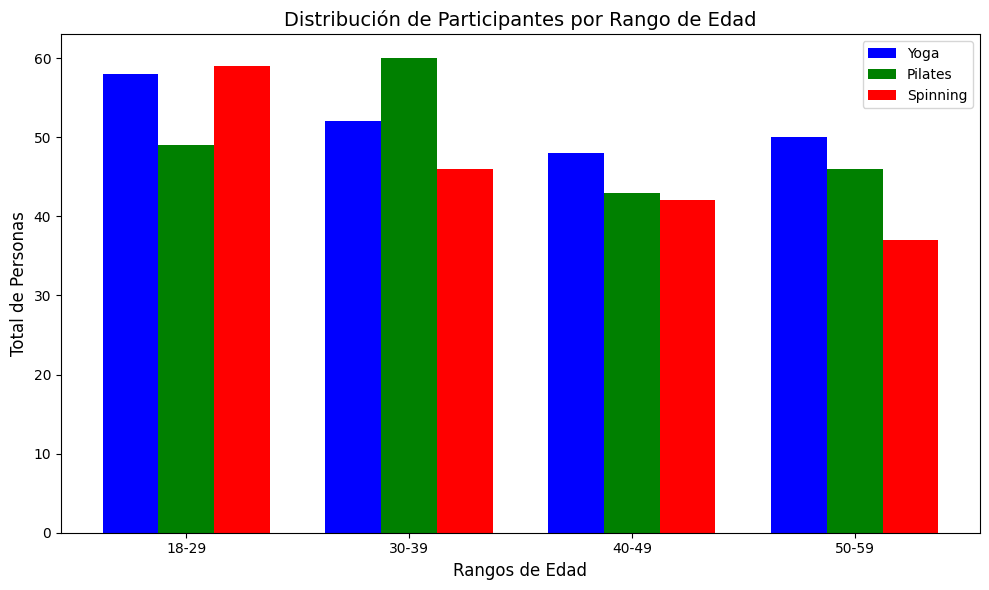

In [11]:
from pyspark.sql.functions import when, col, sum as spark_sum
import pandas as pd
import matplotlib.pyplot as plt

# Función para agrupar por rangos de edad
def agrupar_por_rangos(df):
    return (df.withColumn(
                "rango_edad",
                when((col("edad") >= 18) & (col("edad") <= 29), "18-29")
                .when((col("edad") >= 30) & (col("edad") <= 39), "30-39")
                .when((col("edad") >= 40) & (col("edad") <= 49), "40-49")
                .when((col("edad") >= 50) & (col("edad") <= 59), "50-59")
                .otherwise("Otros")
            )
            .groupBy("rango_edad")
            .agg(spark_sum("count").alias("total"))
            .orderBy("rango_edad")
    )

# Agrupar por rangos de edad para cada actividad
df_yoga_agrupado = agrupar_por_rangos(df_yoga_agrupado)
df_pilates_agrupado = agrupar_por_rangos(df_pilates_agrupado)
df_spinning_agrupado = agrupar_por_rangos(df_spinning_agrupado)

df_yoga_data = df_yoga_agrupado.toPandas()
df_pilates_data = df_pilates_agrupado.toPandas()
df_spinning_data = df_spinning_agrupado.toPandas()

plt.figure(figsize=(10, 6))
bar_width = 0.25
r1 = range(len(df_yoga_data))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.bar(r1, df_yoga_data["total"], color="blue", width=bar_width, label="Yoga")
plt.bar(r2, df_pilates_data["total"], color="green", width=bar_width, label="Pilates")
plt.bar(r3, df_spinning_data["total"], color="red", width=bar_width, label="Spinning")

plt.xlabel("Rangos de Edad", fontsize=12)
plt.ylabel("Total de Personas", fontsize=12)
plt.title("Distribución de Participantes por Rango de Edad", fontsize=14)
plt.xticks([r + bar_width for r in range(len(df_yoga_data))], df_yoga_data["rango_edad"])
plt.legend()
plt.tight_layout()
plt.show()
